In [344]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

145 145 200


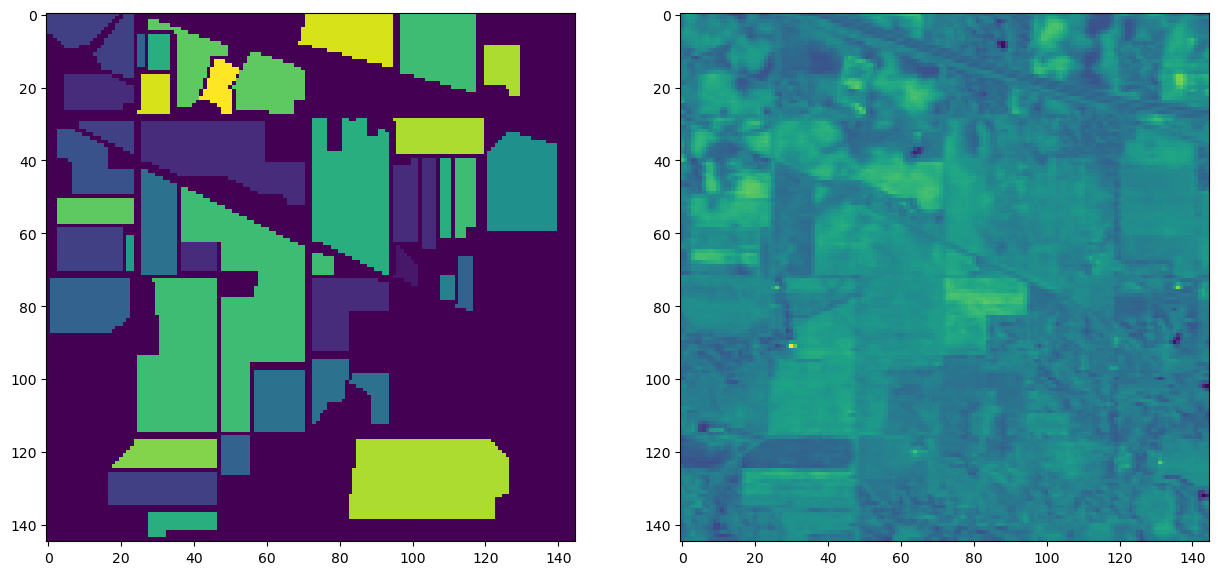

In [462]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)
trainData = Data.standardize_data(trainData)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

### Variability metrics

In [117]:
def anovaFtest(clusters):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    average = np.average([ts for cluster in clusters for ts in cluster], axis=0)

    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * ((averages[k]-average)**2).sum()
        for ts in clusters[k]:
            WGV += ((ts-averages[k])**2).sum()
    
    return (n-K)/(K-1) * BGV/WGV
    

from sklearn.metrics import davies_bouldin_score
def DaviesBouldinIndex(clusters):
    # Lower value means better clustering then we invert
    labels = [i for i,cluster in enumerate(clusters) for _ in range(len(cluster))]
    X = [ts for cluster in clusters for ts in cluster]
    return 1/davies_bouldin_score(X, labels)


from sklearn.metrics import silhouette_score
def SilhouetteScore(clusters):
    # Higher value (close to 2) means high separability
    labels = [i for i,cluster in enumerate(clusters) for _ in range(len(cluster))]
    X = [ts for cluster in clusters for ts in cluster]
    return silhouette_score(X, labels)+1


In [118]:
def compute_medoid(group, simFun=ERS.norm2_similarity):
    group = [np.array(gi) for gi in group]
    n,_ = group.shape
    distances = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if i!=j:
                distances[i] += simFun(group[i], group[j])
    metroid_index = np.argmin(distances)
    return group[metroid_index]


def medoidAnovaFtest(clusters):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    medoids = np.array([compute_medoid(cluster) for cluster in clusters])
    medoid = compute_medoid([ts for cluster in clusters for ts in cluster])

    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * ((medoids[k]-medoid)**2).sum()
        for ts in clusters[k]:
            WGV += ((ts-medoids[k])**2).sum()
    
    return (n-K)/(K-1) * BGV/WGV
    


def medoidDaviesBouldinIndex(clusters):
    # Lower value means better clustering then we invert
    K = len(clusters)
    dist = ERS.norm2_similarity
    medoids = np.array([compute_medoid(cluster) for cluster in clusters])
    distances = np.array([np.average([dist(medoids[k], ts) for ts in cluster]) for k,cluster in enumerate(clusters)])
    R = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            R[i,j] = (distances[i]+distances[j])/dist(medoids[i], medoids[j])
    
    DBI = 0
    for i in range(K):
        maxi = 0
        for j in range(K):
            if i!=j and R[i,j]>maxi:
                maxi=R[i,j]
        DBI += maxi
    DBI = DBI/K

    return 1/DBI

# Multi-level algo

### Choice of Ks

$min_{K_s} = 20$ ?, $max_{K_s} = 3\times K$ ?

$K_s$ = [20,50,100, 200, 400, 800..., $max_{K_s}$]

In [ ]:
def anovaFtest(clusters):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    average = np.average([ts for cluster in clusters for ts in cluster], axis=0)

    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * ((averages[k]-average)**2).sum()
        for ts in clusters[k]:
            WGV += ((ts-averages[k])**2).sum()
    
    return (n-K)/(K-1) * BGV/WGV


def compute_Ks(K, N,M):
    Ksmin = min(20, int(K/4))
    Ksmax = int(N*M/20)
    Ks = [Ksmin, 50]
    k = 100
    while k<Ksmax:
        Ks.append(k)
        k *=2
    Ks.sort()
    return Ks


from sklearn.decomposition import PCA
def createInfo(data, Ks):
    SPsDic = ERS.find_superpixel(data, Ks, lambda_coef="auto", simFun="norm1")
    associations = np.zeros((len(Ks), N, M), dtype=int)
    for level, K in enumerate(Ks):
        SPs = SPsDic[K]
        for k,SP in enumerate(SPs):
            for x,y in SP:
                associations[level][x,y] = k

    def getSP(level, idSP):
        return SPsDic[Ks[level]][idSP]

    getParent = [[None for _ in range(len(SPsDic[K]))] for K in Ks]
    for level in range(1,len(Ks)):
        for k, SP in enumerate(SPsDic[Ks[level]]):
            getParent[level][k] = associations[level-1][SP[0]]


    getChilds = [[[] for _ in range(len(SPsDic[K]))] for K in Ks]
    for level in range(1, len(Ks)):
        SPs = SPsDic[Ks[level]]
        for k, SP in enumerate(SPs):
            botId = getParent[level][k]
            getChilds[level-1][botId] += [k]


    def divide_comp_var(level, idSP, n_component=0, varFun=anovaFtest):
        childsID = getChilds[level][idSP]
        if len(childsID)==0: return 0
        if len(childsID)==1: return 1e9

        childs = [getSP(level+1, id) for id in childsID]
        if n_component==0:
            return varFun(childs)
        
        clusters_id = [i for i,child in enumerate(childs) for _ in range(len(child))]
        TS = np.array([trainData[coor] for child in childs for coor in child])

        n_component = min(n_component, min(TS.shape))
        pca = PCA(n_components=n_component)
        coeffs = pca.fit_transform(TS)

        clusters = [[] for i in range(len(childs))]
        for i in range(len(clusters_id)):
            clusters[clusters_id[i]].append(coeffs[i])
        #clusters = [np.array(cluster) for cluster in clusters]
        return varFun(clusters)

    return SPsDic, getSP, getParent, getChilds, divide_comp_var


from classes import MinHeap
def multilevel_splitSP(data, K, n_component=0, usedVarFun=anovaFtest, infos=None):
    N,M,_ = data.shape
    Ks = compute_Ks(K,N,M)
    if infos==None:
        infos = createInfo(data, Ks)
    SPsDic, getSP, getParent, getChilds, divide_comp_var = infos

    heap = MinHeap()
    for k in range(len(SPsDic[Ks[0]])):
        heap.insert((0, k), -divide_comp_var(0, k, n_component, varFun=usedVarFun))

    while 0<len(heap.array)<K:
        elt,w = heap.pop()
        level, idSP = elt
        childsID = getChilds[level][idSP]
        if childsID==[]:
            heap.insert((level, idSP), 0)
            break
        for id in childsID:
            heap.insert((level+1, id), -divide_comp_var(level+1, id, n_component, varFun=usedVarFun))

    return [getSP(pair.first[0], pair.first[1]) for pair in heap.array]

### Compute SPs

In [ ]:
Ks = [20, 50, 100, 200, 400, 800]

In [ ]:
SPsDic = ERS.find_superpixel(trainData, Ks,
                             lambda_coef="auto",
                             simFun="norm1")

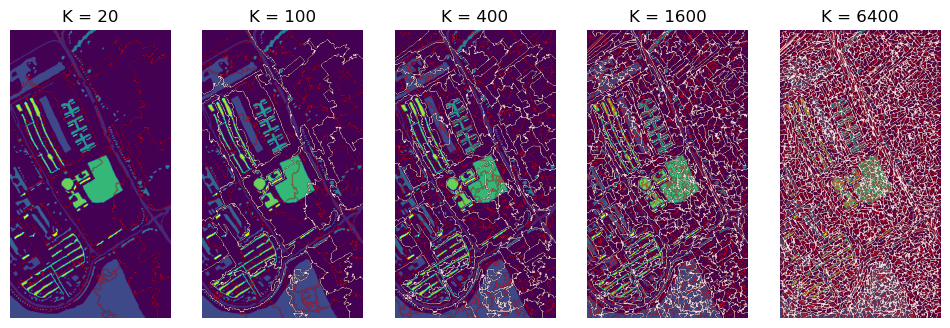

In [431]:
n,m = 1,5
Ks_id_to_plot = np.unique(np.round(np.linspace(0,len(Ks)-1, n*m)).astype(int))
Ks2D = np.array([Ks[i] for i in Ks_id_to_plot]).reshape(n,m)

fig, axs = plt.subplots(n, m, figsize=(12,6))
axs = axs.reshape(n,m)
for i in range(n):
    for j in range(m):
        axs[i,j].axis("off")
        axs[i,j].imshow(usedDataset["gt"])
        axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[i,j]], color=[255,0,0,150]))
        if i+j>0:
            pred = (i,j-1) if j>0 else (i-1, m-1)
            axs[i,j].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks2D[pred]], color=[255,255,255,220]))
        axs[i,j].title.set_text("K = " + str(Ks2D[i,j]))
plt.show()

In [ ]:
associations = np.zeros((len(Ks), N, M), dtype=int)
for level, K in enumerate(Ks):
    SPs = SPsDic[K]
    for k,SP in enumerate(SPs):
        for x,y in SP:
            associations[level][x,y] = k


def getSP(level, idSP):
    return SPsDic[Ks[level]][idSP]

getParent = [[None for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1,len(Ks)):
    for k, SP in enumerate(SPsDic[Ks[level]]):
        getParent[level][k] = associations[level-1][SP[0]]


getChilds = [[[] for _ in range(len(SPsDic[K]))] for K in Ks]
for level in range(1, len(Ks)):
    SPs = SPsDic[Ks[level]]
    for k, SP in enumerate(SPs):
        botId = getParent[level][k]
        getChilds[level-1][botId] += [k]

50


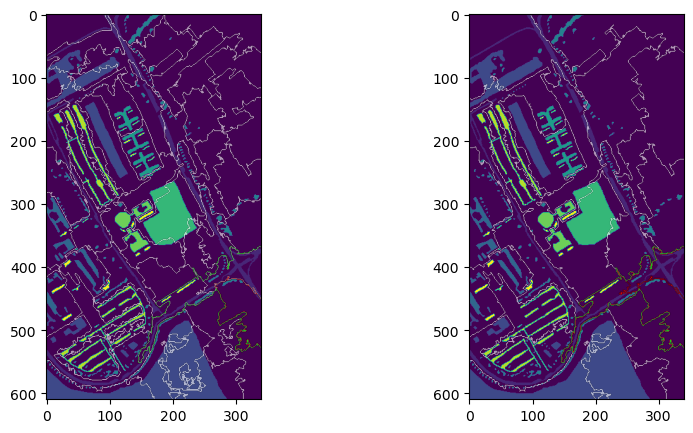

In [434]:
level = np.random.randint(1, len(Ks)-1)
idSP = np.random.randint(0, len(SPsDic[Ks[level]])-1)
SP = getSP(level, idSP)
parentID = getParent[level][idSP]
parent = getSP(level-1, parentID)
childs = [getSP(level, id) for id in getChilds[level-1][parentID]]

print(Ks[level])
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(usedDataset["gt"])
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level]], color=[255,255,255,150]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [SP], color=[255,0,0,250]))
axs[0].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))

axs[1].imshow(usedDataset["gt"])
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level-1]], color=[255,255,255,150]))
for child in childs:
    axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [child], color=[255,0,0,250]))
axs[1].imshow(ERS.create_overlay_borders(usedDataset["gt"], [parent], color=[0,255,0,250], exterior=True))
plt.show()

### variability comparaison

In [435]:
from sklearn.decomposition import PCA

def divide_comp_var(level, idSP, n_component=0, varFun=anovaFtest, do_plot=False):
    childsID = getChilds[level][idSP]
    if len(childsID)==0: return 0
    if len(childsID)==1: return 1e9

    childs = [getSP(level+1, id) for id in childsID]
    if n_component==0:
        return varFun(childs)
    
    clusters_id = [i for i,child in enumerate(childs) for _ in range(len(child))]
    TS = np.array([trainData[coor] for child in childs for coor in child])

    n_component = min(n_component, min(TS.shape))
    pca = PCA(n_components=n_component)
    coeffs = pca.fit_transform(TS)

    if do_plot:
        colors = mpl.colormaps["jet"](np.linspace(0, 1, len(childs)))
        coors = [coor for child in childs for coor in child]
        plt.imshow(usedDataset["gt"])
        mask = ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level+1]], color=[255,255,255,200])
        for i in range(len(clusters_id)):
            mask[coors[i]] = colors[clusters_id[i]]*255
        plt.imshow(mask)
        plt.show()

        if n_component==3:
            plt.figure().add_subplot(projection="3d")
        for i in range(len(clusters_id)):
            if n_component==3:
                plt.plot(coeffs[i][0], coeffs[i][1], coeffs[i][2], "x", color=colors[clusters_id[i]])
            elif n_component==2:
                plt.plot(coeffs[i][0], coeffs[i][1], "x", color=colors[clusters_id[i]])
            else:
                plt.plot(np.arange(0,n_component), coeffs[i], "x", color=colors[clusters_id[i]])
        plt.show()
    

    clusters = [[] for i in range(len(childs))]
    for i in range(len(clusters_id)):
        clusters[clusters_id[i]].append(coeffs[i])
    #clusters = [np.array(cluster) for cluster in clusters]
    return varFun(clusters)



level = 0
idSP = 5
n_component = 5

do_plot = False
if do_plot:
    plt.imshow(usedDataset["gt"])
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPsDic[Ks[level+1]], color=[255,255,255,200]))
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [getSP(level, idSP)], color=[255,0,0,200]))
    plt.show()
val = divide_comp_var(level, idSP, n_component, do_plot=do_plot, varFun=SilhouetteScore)
print(val)

1.234782391170666


### Algorithm

In [436]:
from classes import MinHeap

def split_SPs(K, n_component=0, usedVarFun=anovaFtest):
    heap = MinHeap()
    for k in range(len(SPsDic[Ks[0]])):
        heap.insert((0, k), -divide_comp_var(0, k, n_component, varFun=usedVarFun))

    while 0<len(heap.array)<K:
        elt,w = heap.pop()
        level, idSP = elt
        childsID = getChilds[level][idSP]
        if childsID==[]:
            heap.insert((level, idSP), 0)
            break
        for id in childsID:
            heap.insert((level+1, id), -divide_comp_var(level+1, id, n_component, varFun=usedVarFun))
        
        """
        SPs = [getSP(pair.first[0], pair.first[1]) for pair in heap.array]
        plt.imshow(usedDataset["gt"])
        plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200]))
        plt.show()
        """

    return [getSP(pair.first[0], pair.first[1]) for pair in heap.array]

In [444]:
K = 500
SPs = split_SPs(K, n_component=0, usedVarFun=anovaFtest)

In [445]:
SPs2 = split_SPs(K, n_component=6, usedVarFun=anovaFtest)

# Graph-Based algo

### Choice of $K_{or}$

Want $K$ respecting two criteria:

First criteria:
$$\frac{N M}{K} \geq P_{avg} \Leftrightarrow K\leq \frac{NM}{P_{avg}}$$
with $P_{avg}$ a constant (=20).

Second Criteria:
$$P_s \geq \delta \Leftrightarrow f(\frac{NM}{K}) \geq \frac{\delta}{\gamma} \Leftrightarrow K \leq \frac{NM}{f^{-1}(\frac{\delta}{\gamma})}$$
with $\delta$ the number of component used in PCA, $f : x \mapsto x ln^2(x)$.

Therefore, the criteria on $K$ can be merge to get:
$$ K\leq \frac{NM}{max(P_{avg},\; f^{-1}(\frac{\delta}{\gamma}))}$$

In [121]:
from scipy.optimize import root_scalar
def f(x):
    return x * np.log(np.log(x))

def f_inverse(y, x0=5.0):
    if y <= 0:
        raise ValueError("f(x) = x log(log(x)) is only defined for x > e")
    
    def equation(x):
        return f(x) - y
    
    result = root_scalar(equation, bracket=[np.e + 1e-5, 1e10], method='brentq')
    return result.root

P_avg = 20
gamma = 0.15
n_component = 10
choosen_max = max(P_avg, f_inverse(n_component/gamma))
print(choosen_max)
K_or = int(N*M/choosen_max)
print(K_or)

49.05055563858078
428


### Compute SPs

In [139]:
SPs_or = ERS.find_superpixel(trainData, K_or, lambda_coef="auto", simFun="norm1")
pixelToSP = np.zeros((N,M), dtype=int)
for k,SP in enumerate(SPs):
    for x,y in SP:
        pixelToSP[x,y] = k

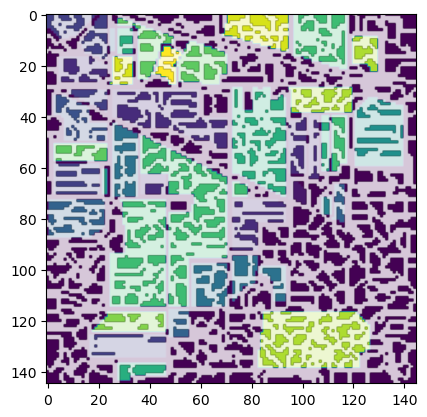

In [140]:
plt.imshow(usedDataset["gt"])
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_or, color=[255,255,255,200]))
plt.show()  

In [141]:
neighboors = [set() for _ in range(len(SPs_or))]
borders = ERS.find_borders(SPs_or, (N,M), exterior=True)
for k1 in range(len(borders)):
    for x,y in borders[k1]:
        k2 = pixelToSP[x,y]
        neighboors[k1].add(k2)

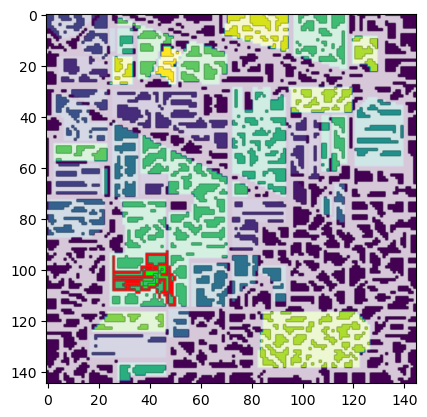

In [142]:
k1 = np.random.randint(0, len(SPs_or)-1)
plt.imshow(usedDataset["gt"])
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_or, color=[255,255,255,200]))
plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [SPs_or[k1]], color=[0,255,0,250]))
for k2 in neighboors[k1]:
    plt.imshow(ERS.create_overlay_borders(usedDataset["gt"], [SPs_or[k2]], color=[255,0,0,250]))
plt.show() 

In [215]:
def merge_SP(SPs_or, neighboors_or, K, trainData, n_component=0, varFun=anovaFtest):
    def insert_sorted(l, elt):
        _,_,w = elt
        left, right = 0, len(l)
        while left < right:
            mid = (left+right)//2
            if l[mid][2]<w:
                left = mid+1
            else:
                right = mid
        l.insert(left, elt)


    def simFun(group1, group2, n_component=n_component):
        if n_component==0:
            return varFun([group1, group2])
        else:
            TS = np.array([trainData[coor] for group in [group1, group2] for coor in group])
            n_component = min(n_component, min(TS.shape))
            pca = PCA(n_components=n_component)
            coeffs = pca.fit_transform(TS)

            clusters = [[], []]
            for i in range(len(group1)):
                clusters[0].append(coeffs[i])
            for i in range(len(group2)):
                clusters[1].append(coeffs[i+len(group1)])
            #clusters = [np.array(cluster) for cluster in clusters]
            return varFun(clusters)


    SPs = [SP.copy() for SP in SPs_or]
    neighboors:list[set] = [neighboor.copy() for neighboor in neighboors_or]

    nb_cc = len(SPs)
    existing = [True for _ in range(nb_cc)]
    edges = [(u, v, simFun(SPs[u], SPs[v])) for u in range(nb_cc)
                for v in neighboors[u] if u<v]
    edges.sort(key=lambda x:x[2])
    
    while nb_cc > K and len(edges)>0:
        k1,k2,_ = edges.pop(0)
        if existing[k1] and existing[k2]:
            """
            print(len(edges))
            neighboorhoods_sizes = [len(neighboors[k]) for k in range(len(SPs)) if existing[k]]
            neighboorhoods_sizes.sort(key=lambda x:-x)
            print(neighboorhoods_sizes)
            """
            existing[k2] = False
            SPs[k1] += SPs[k2]
            SPs[k2] = None
            neighboors[k1] = neighboors[k1].union(neighboors[k2])
            neighboors[k2] = None

            edges = [(u,v,w) for u,v,w in edges if u!=k1 and v!=k2 and u!=k2 and v!=k1 and existing[u] and existing[v]]
            for v in neighboors[k1]:
                if v!=k1 and existing[v]:
                    insert_sorted(edges, (k1,v, simFun(SPs[k1], SPs[v])))
            
            nb_cc -=1

    return [SP for i,SP in enumerate(SPs) if existing[i]]


In [231]:
K = 100
usedVarFun = lambda x:anovaFtest(x)
SPs = merge_SP(SPs_or, neighboors, K, trainData,
               n_component=0,
               varFun=usedVarFun)

# Result

In [476]:
basic_Ks = [100, 200, 300, 500, 700, 900, 1100, 1300, 1700, 2100]
basic_Ks = [100,300]
basic_SPsDic = ERS.find_superpixel(trainData, basic_Ks, lambda_coef="auto", simFun="norm1")

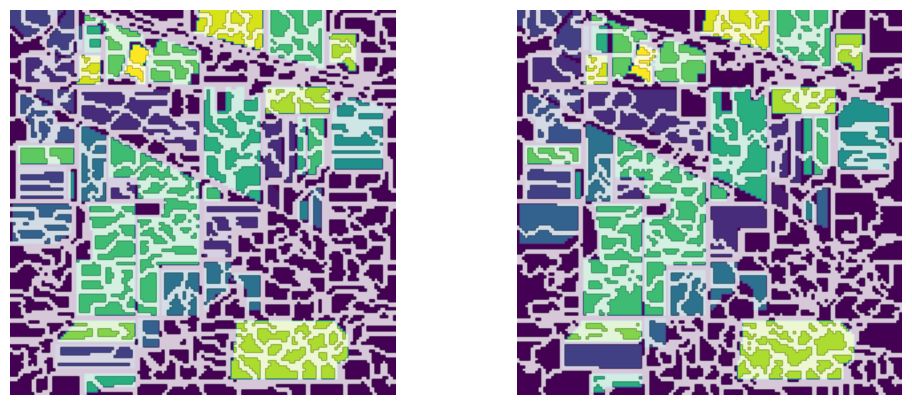

In [480]:
SPs_list = [basic_SPs, SPs] #+ [SPs2]
fig, axs = plt.subplots(1,len(SPs_list), figsize=(12,5))
for i in range(len(SPs_list)):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SPs_list[i], color=[255,255,255,200]))
    axs[i].set_axis_off()
plt.show()

In [481]:
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = [
        ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                for SPs in SPs_list
        ]

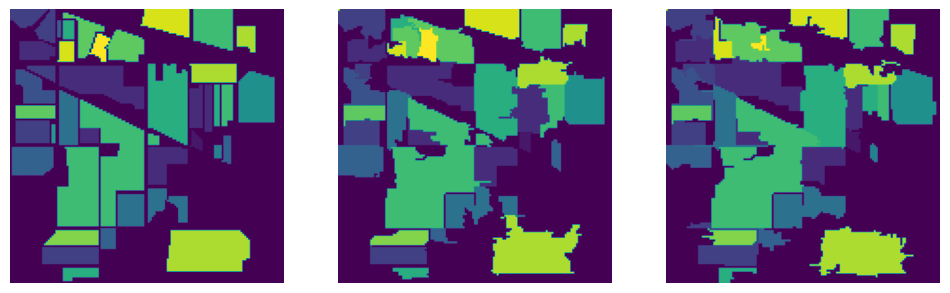

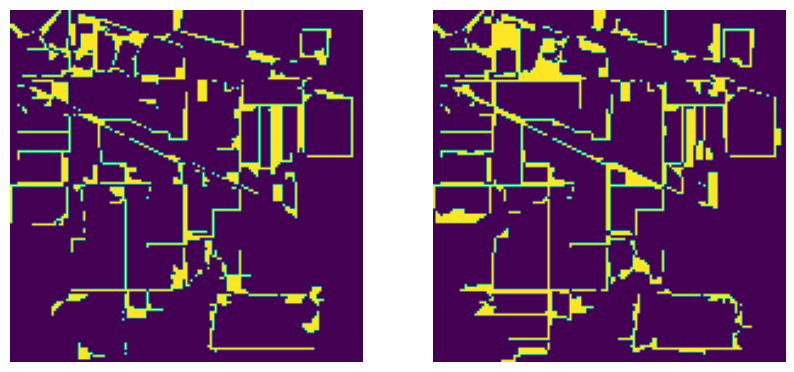

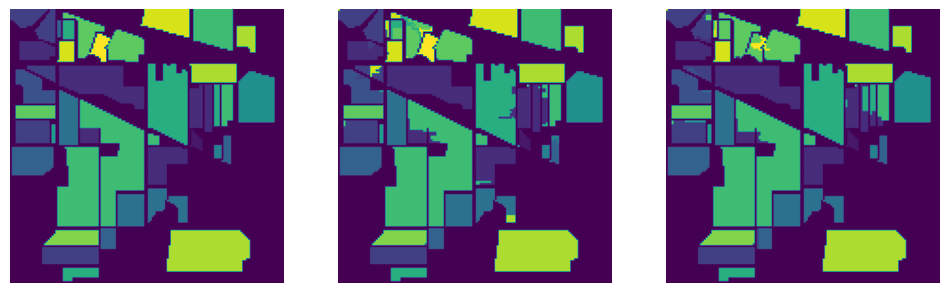

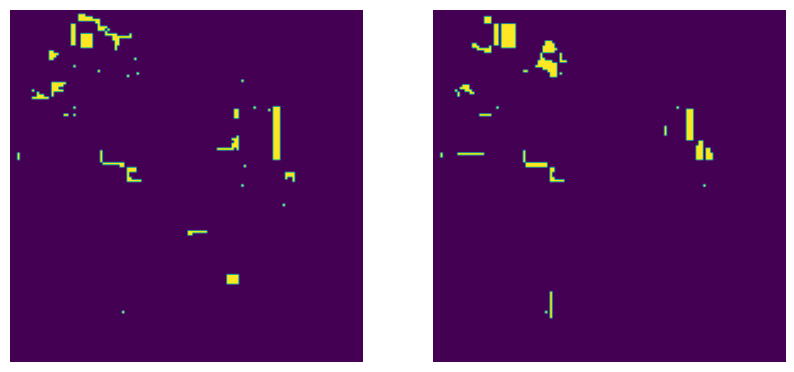

In [482]:
for b in [True, False]:
    fig, axs = plt.subplots(1,1+len(SPs_list), figsize=(12,5))
    axs[0].imshow(usedDataset["gt"])
    axs[0].set_axis_off()
    for i in range(len(SPs_list)):
        img = ClassifierDic[b][i].guess_map.copy()
        img[0,0] = max(usedDataset["labels"])
        axs[i+1].imshow(img)
        axs[i+1].set_axis_off()
    plt.show()

    
    fig, axs = plt.subplots(1,len(SPs_list), figsize=(10,5))
    for i in range(len(SPs_list)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=ClassifierDic[b][i].guess_map[x,y]:
                    new_img[x,y] = 1
        axs[i].imshow(new_img)
        axs[i].set_axis_off()
    plt.show()

In [483]:
for b in [True, False]:
    print(b)
    for i in range(len(SPs_list)):
        print(i)
        classifier:ERS.SuperpixelClassifier = ClassifierDic[b][i]
        print("OA:", classifier.overallAccuracy(usedDataset["gt"]))
        print("AA:", classifier.averageAccuracy(usedDataset["gt"]))
        print("SCP:", classifier.singleClassProportion())
        print("ACP:", classifier.averageProportion())
        print("AWJS:", classifier.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"]))


True
0
OA: 0.8760047562425683
AA: 0.7981579036520522
SCP: 0.48333333333333334
ACP: 0.8787523225216861
AWJS: 0.045921588167489064
1
OA: 0.857217598097503
AA: 0.8119999524370652
SCP: 0.49666666666666665
ACP: 0.877410028980284
AWJS: 0.04428040585231908
False
0
OA: 0.9675090252707581
AA: 0.9689223728702989
SCP: 0.8449197860962567
ACP: 0.9629473694930422
AWJS: 0.05863729799361837
1
OA: 0.9668260318079812
AA: 0.9337628714675781
SCP: 0.8586387434554974
ACP: 0.9689080199350899
AWJS: 0.05867077791665901
